In [1]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [2]:
# Import the relevant modules
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from sousvide.control.pilot import Pilot

/home/admin/anaconda3/envs/sv-env/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.3' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
cohort = "spread001"                       # cohort name

In [30]:
def extract_data(cohort, pilot, data):
    TT,CC,Theta,ZZ,QQ = [],[],[],[],[]
    for flight in data[pilot]:
        policy = Pilot(cohort,pilot)
        policy.set_mode("deploy")
        test_data = torch.load(flight)

        Ndata = test_data["Xest"].shape[1]
        obj = test_data["obj"]

        if test_data["Imgs"].shape[0] != Ndata:
            Ndup = Ndata//test_data["Imgs"].shape[0]
            test_data["Imgs"] = np.repeat(test_data["Imgs"],Ndup,axis=0)

        upr = test_data["Uact"][:,0]
        theta = np.zeros((2,Ndata))
        for i in range(Ndata):
            tcr = test_data["Tact"][i]
            xcr = test_data["Xest"][:,i]
            icr = test_data["Imgs"][i,:,:,:]

            _,znn,_,_,_ = policy.OODA(upr,tcr,xcr,obj,icr,None)

            upr = test_data["Uact"][:,i]

            theta[:,i] = znn.cpu().numpy()

        c_out = np.zeros(Ndata)
        for i in range(Ndata):
            c_out[i] = theta[1,i]/theta[0,i]

        TT.append(test_data["Tact"])
        CC.append(c_out)
        Theta.append(theta)
        ZZ.append(test_data["Xest"][2,:])

    return TT,CC,Theta,ZZ

In [5]:
data = {}
for entry in os.scandir(f"../cohorts/{cohort}/flight_data"):
    data_paths = []
    for root, dirs, files in os.walk(entry.path):
        for file in files:
            if file.endswith(".pt"):
                file_name = os.path.join(root, file)
                data_paths.append(file_name)

    data[entry.name] = data_paths
print(data.keys())

dict_keys(['Jester', 'JesterSim', 'JesterLong'])


In [31]:
TT_sim,CC_sim,_,Z_sim = extract_data(cohort, "JesterSim", data)
TT_real,CC_real,_,Z_real = extract_data(cohort, "Jester", data)

In [ ]:
TT_lg,CC_lg,_,Z_lg = extract_data(cohort, "JesterLong", data)
TT_real,CC_real,_,Z_real = extract_data(cohort, "JesterLongSim", data)

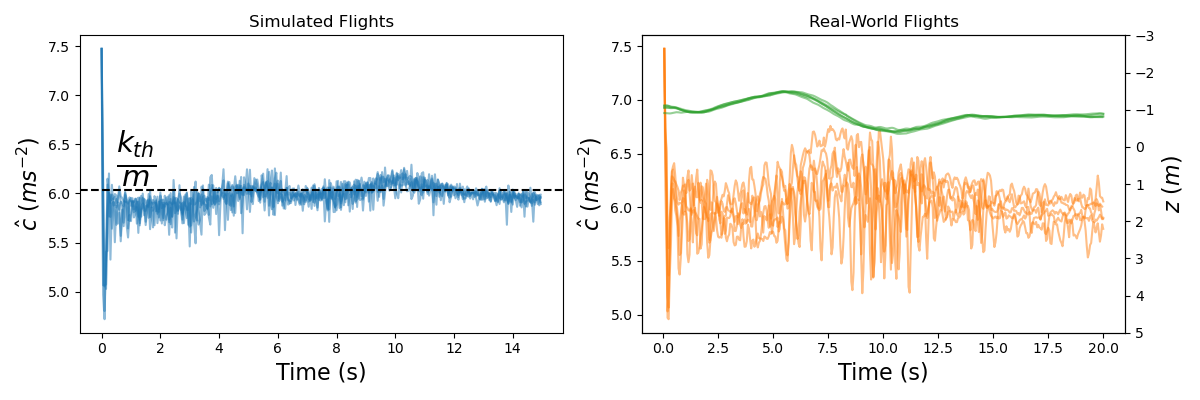

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax2 = axs[1].twinx()

for i in range(len(TT_sim)):
    axs[0].plot(TT_sim[i], CC_sim[i], color="tab:blue", alpha=0.5)

axs[0].set_title("Simulated Flights")
axs[0].set_xlabel("Time (s)", fontsize=16)
axs[0].set_ylabel(r"$\hat{c} \ (ms^{-2})$", fontsize=16)
axs[0].axhline(y=6.031467, color='black', linestyle='--')
axs[0].text(0.5, 6.031467, r'$\frac{k_{th}}{m}$', color='black', ha='left', va='bottom', fontsize=30)

for i in range(len(TT_real)):
    axs[1].plot(TT_real[i], CC_real[i], color="tab:orange", alpha=0.5)
    ax2.plot(TT_real[i], Z_real[i], color="tab:green", alpha=0.5)

axs[1].set_title("Real-World Flights")
axs[1].set_xlabel("Time (s)", fontsize=16)
axs[1].set_ylabel(r"$\hat{c} \ (ms^{-2})$", fontsize=16)
ax2.set_ylabel(r"$z \ (m)$", fontsize=16)
ax2.invert_yaxis()
ax2.set_ylim(5.0,-3.0)

plt.tight_layout()
plt.show()